In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from PIL import Image
import shutil

from sklearn.preprocessing import StandardScaler

from skimage.feature import hog
from skimage import exposure

from skimage import feature
from skimage import filters, feature

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

import warnings

warnings.filterwarnings('ignore')


In [3]:
def compute_edges(image, sigma=1.0):
    
    edge_image = feature.canny(image, sigma=sigma)
    return edge_image


In [4]:
def compute_lbp(image, P=8, R=1):

    lbp_image = feature.local_binary_pattern(image, P=P, R=R, method="uniform")
    return lbp_image


{'R': 573, 'U': 573, '9': 573, '0': 573, '7': 573, 'I': 573, 'N': 573, 'G': 573, '6': 573, 'Z': 573, '1': 573, '8': 573, 'T': 573, 'S': 573, 'A': 573, 'F': 573, 'O': 573, 'H': 573, 'M': 573, 'J': 573, 'C': 573, 'D': 573, 'V': 573, 'Q': 573, '4': 573, 'X': 573, '3': 573, 'E': 573, 'B': 573, 'K': 573, 'L': 573, '2': 573, 'Y': 573, '5': 573, 'P': 573, 'W': 573}


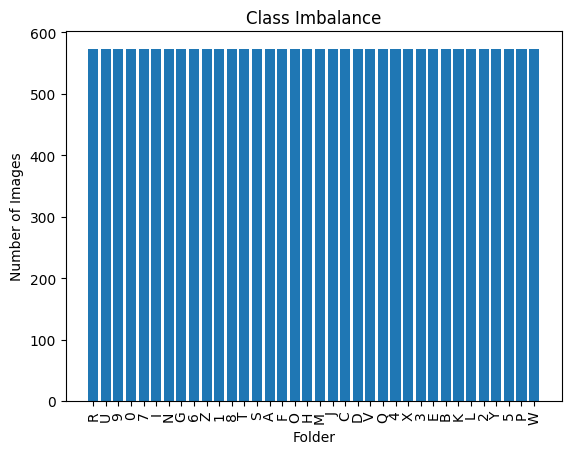

In [5]:

archive_path = 'archive/data/'

d = {}

for root, dirs, files in os.walk(archive_path):
    
    for folder in dirs:

        if folder == "training_data":
            
            testing_data_path = os.path.join(root, folder)
            
            for sub_root, sub_dirs, sub_files in os.walk(testing_data_path):
                
                for sub_folder in sub_dirs:
                    
                    subfolder_path = os.path.join(sub_root, sub_folder)
                    num_images = len(os.listdir(subfolder_path))
                    d[sub_folder] = num_images
                            
print(d)
folders = list(d.keys())
num_images = list(d.values())

plt.bar(folders, num_images)
plt.xlabel('Folder')
plt.ylabel('Number of Images')
plt.title('Class Imbalance')
plt.xticks(rotation=90)
plt.show()

In [6]:
# from the graph it is clear that there is no class imabalance and 
# each folder contains the same number of images for the test data 
# so there is no need of performing oversampling or undersampling.

In [7]:
#Image Resizing

output_path = 'resized_archive' 
 
os.makedirs(output_path, exist_ok=True)

for root, dirs, files in os.walk(archive_path):

    relative_path = os.path.relpath(root, archive_path)
    output_dir = os.path.join(output_path, relative_path)
    os.makedirs(output_dir, exist_ok=True)

    for file in files:

        input_image_path = os.path.join(root, file)
        output_image_path = os.path.join(output_dir, file)

        with Image.open(input_image_path) as img:
            img = img.resize((38, 38), Image.LANCZOS)
            img.save(output_image_path)



In [8]:
# Color Conversion --> convert everything to grey scale


resized_archive_path = 'resized_archive'
final_archive_path = 'final_archive'  


os.makedirs(final_archive_path, exist_ok=True)

edge_map_dict = {}

lbp_map_dict = {}

for root, dirs, files in os.walk(resized_archive_path):

    relative_path = os.path.relpath(root, resized_archive_path)
    final_dir = os.path.join(final_archive_path, relative_path)
    os.makedirs(final_dir, exist_ok=True)

    for file in files:

        if file.endswith('.jpg') or file.endswith('.png'):
            input_image_path = os.path.join(root, file)
            output_image_path = os.path.join(final_dir, file)

            with Image.open(input_image_path) as img:
                img = img.convert('L')
                img.save(output_image_path)
                
                img_array = np.array(img)
                
                edge_img = compute_edges(img_array)
            
                label = os.path.basename(root)
                if label not in edge_map_dict:
                    edge_map_dict[label] = []
                edge_map_dict[label].append(edge_img)


                lbp_img = compute_lbp(img_array)
                if label not in lbp_map_dict:
                    lbp_map_dict[label] = []
                lbp_map_dict[label].append(lbp_img)
                
                       

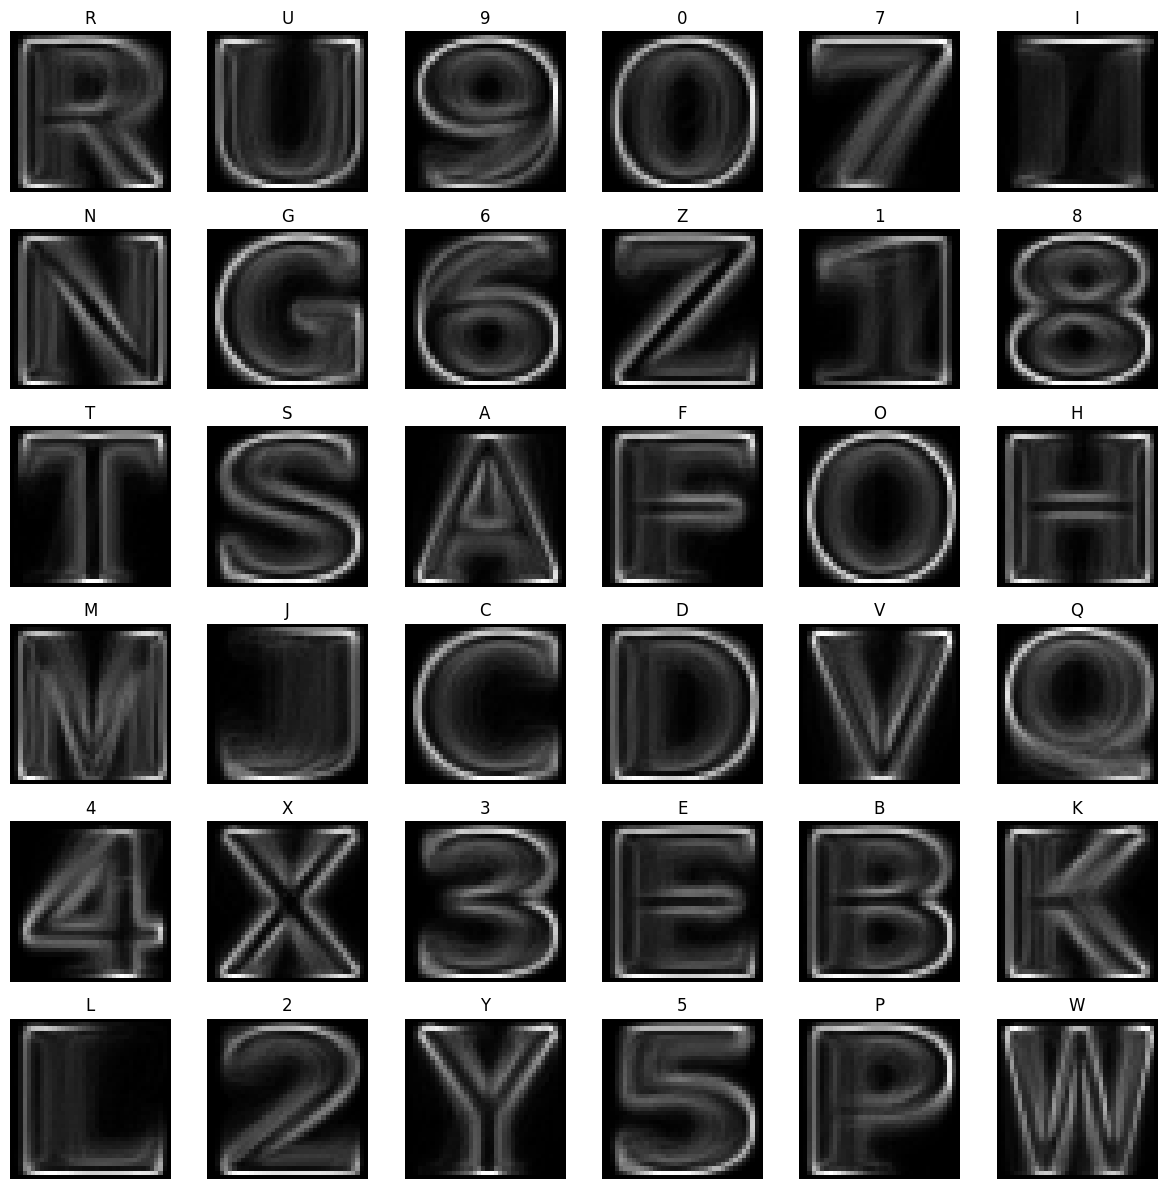

In [9]:
# Plotting the mean Edge Detected Image

fig, axs = plt.subplots(6, 6, figsize=(12, 12)) 
axs = axs.ravel()

for idx, (label, edge_images) in enumerate(edge_map_dict.items()):
    mean_edge_image = np.mean(edge_images, axis=0)
    axs[idx].imshow(mean_edge_image, cmap='gray')
    axs[idx].set_title(label)
    axs[idx].axis('off')

plt.tight_layout()
plt.show()        
         

In [10]:
'''
By looking at the Images of each class after performing the Edge Detection we can infer the following 

There are distinctive Edge Patterns among the classes : 
Each character and digit presents a unique edge pattern. 
The sharpness, continuity, and layout of these edges are distinctive for each class. 
For instance, the number "8" has two clear circular patterns, 
while the letter "A" has a distinct peak with a horizontal crossbar in the middle.
That is 
A has a continuous Edge patterns where in case of a digit Number 8 has not a straight edge pattern but instead 
a circular edge pattern. This can help us in differentiate between class 8 and class A similarly it can be 
extended to other classes as well.

Hence It is very crucial to study the Edge patterns in differnet classes.

'''

'\nBy looking at the Images of each class after performing the Edge Detection we can infer the following \n\nThere are distinctive Edge Patterns among the classes : \nEach character and digit presents a unique edge pattern. \nThe sharpness, continuity, and layout of these edges are distinctive for each class. \nFor instance, the number "8" has two clear circular patterns, \nwhile the letter "A" has a distinct peak with a horizontal crossbar in the middle.\nThat is \nA has a continuous Edge patterns where in case of a digit Number 8 has not a straight edge pattern but instead \na circular edge pattern. This can help us in differentiate between class 8 and class A similarly it can be \nextended to other classes as well.\n\nHence It is very crucial to study the Edge patterns in differnet classes.\n\n'

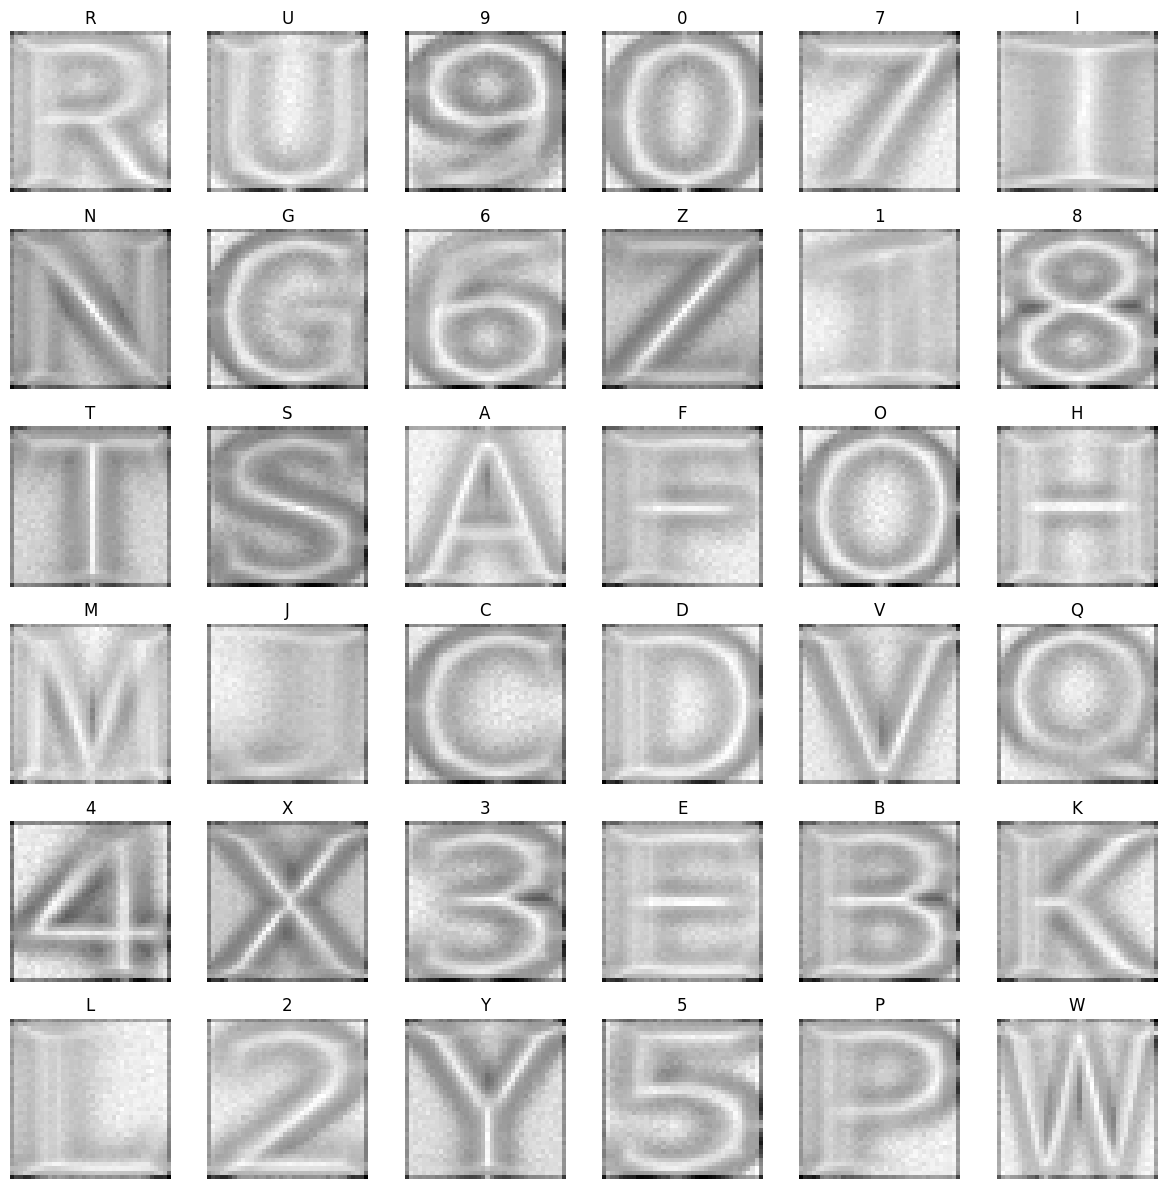

In [11]:
# plotting the LBP images

fig, axs = plt.subplots(6, 6, figsize=(12, 12)) 
axs = axs.ravel()

for idx, (label, lbp_images) in enumerate(lbp_map_dict.items()):
    mean_lbp_image = np.mean(lbp_images, axis=0)
    axs[idx].imshow(mean_lbp_image, cmap='gray')
    axs[idx].set_title(label)
    axs[idx].axis('off')

plt.tight_layout()
plt.show()      

In [12]:
'''
LBP provides a compact representation of the image, 
where the local patterns can be captured with just a few bits per pixel. 
This reduces the dimensionality of the data, making it quicker and often more accurate for classification tasks.
'''

'\nLBP provides a compact representation of the image, \nwhere the local patterns can be captured with just a few bits per pixel. \nThis reduces the dimensionality of the data, making it quicker and often more accurate for classification tasks.\n'

In [13]:
# Extract the data and make it a dataframe

final_archive_path = 'final_archive/training_data'

data = []

for root, dirs, files in os.walk(final_archive_path):
    
    for file in files:

        label = os.path.basename(root)

        image_path = os.path.join(root, file)
        with Image.open(image_path) as img:

            pixel_values = list(img.getdata())


            data.append(pixel_values + [label])

columns = [f'pixel_{i}' for i in range(len(data[0]) - 1)] + ['label']
df = pd.DataFrame(data, columns=columns)

In [14]:
df.shape

(20628, 1445)

In [15]:
# store them according to groups
def normalize_pixels(pixel_values):
    return pixel_values / 255.0


grouped = df.groupby('label')

grouped_df = {}

norm_data_map = {}

for label, group in grouped:
    
    df_normalized = group.copy()

    pixel_intensity_columns = group.columns[:-1]  # Exclude the 'label' column
    
    df_normalized[pixel_intensity_columns] = df[pixel_intensity_columns].apply(normalize_pixels)
    df_normalized['label'] = group['label']
    
    norm_data_map[label] = df_normalized
    
    grouped_df[label] = df_normalized
    
df= pd.concat(norm_data_map.values(), ignore_index=True)

In [16]:
df.shape

(20628, 1445)

In [17]:
# perform tranforamtion on testing_data

# Extract the data and make it a dataframe

final_archive_path = 'final_archive/testing_data'

data = []

for root, dirs, files in os.walk(final_archive_path):
    
    for file in files:

        label = os.path.basename(root)

        image_path = os.path.join(root, file)
        with Image.open(image_path) as img:

            pixel_values = list(img.getdata())

            data.append(pixel_values + [label])


columns = [f'pixel_{i}' for i in range(len(data[0])-1)] + ["label"]
test_df = pd.DataFrame(data, columns=columns)


# store them according to groups
def normalize_pixels(pixel_values):
    return pixel_values / 255.0


grouped = test_df.groupby('label')

norm_test_data_map = {}

for label, group in grouped:

    df_normalized = group.copy()
    
    pixel_intensity_columns = group.columns[:-1]  # Exclude the 'label' column
    
    df_normalized[pixel_intensity_columns] = test_df[pixel_intensity_columns].apply(normalize_pixels)
    df_normalized['label'] = group['label']
    
    norm_test_data_map[label] = df_normalized

test_df= pd.concat(norm_test_data_map.values(), ignore_index=True)

In [18]:
test_df.shape

(1008, 1445)

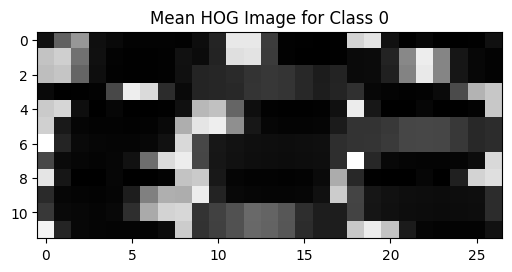

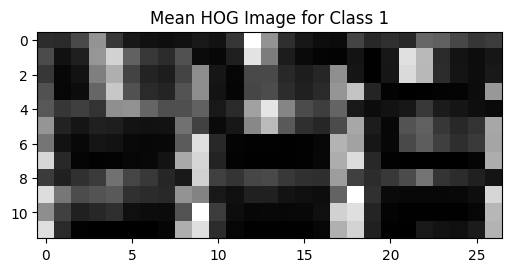

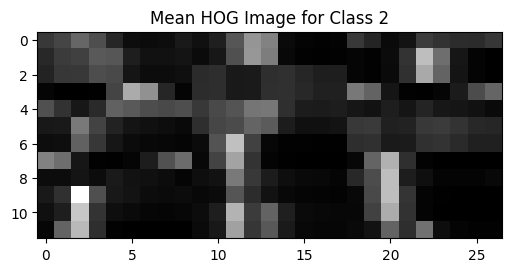

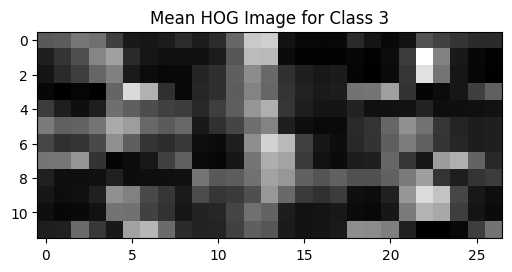

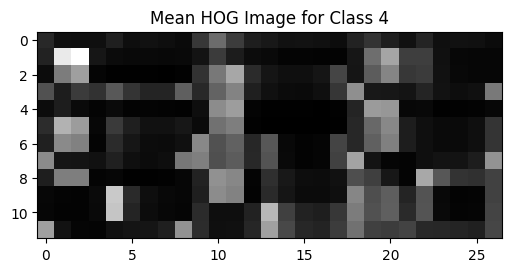

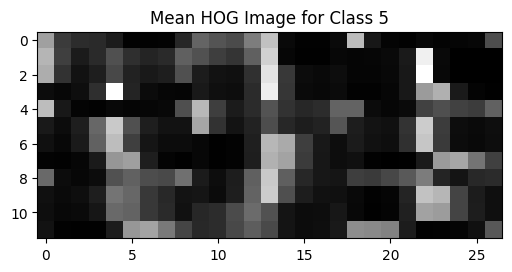

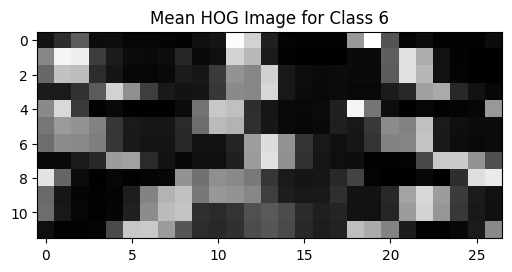

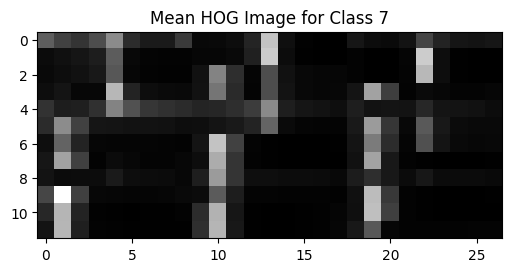

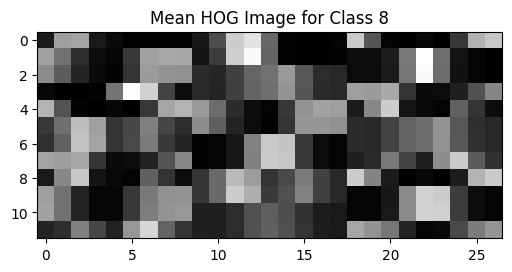

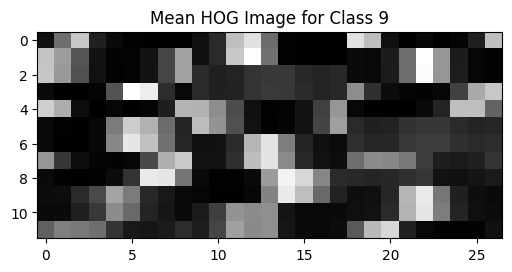

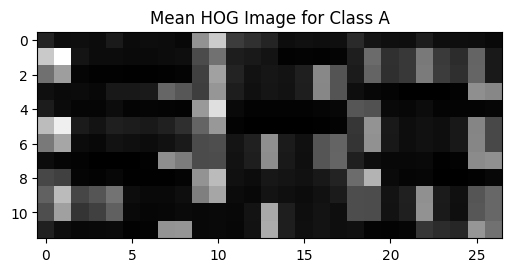

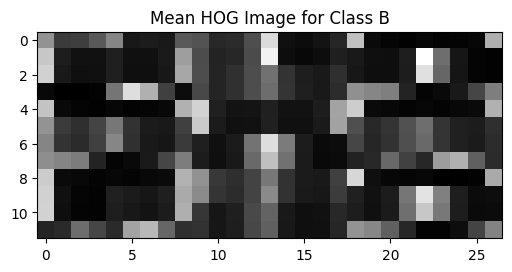

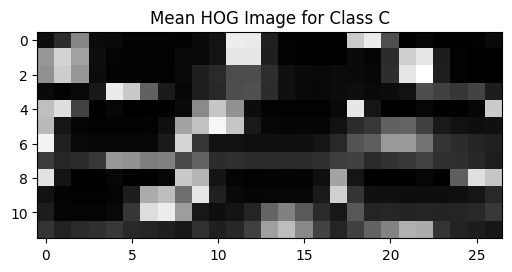

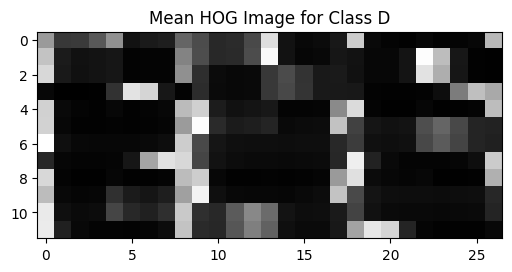

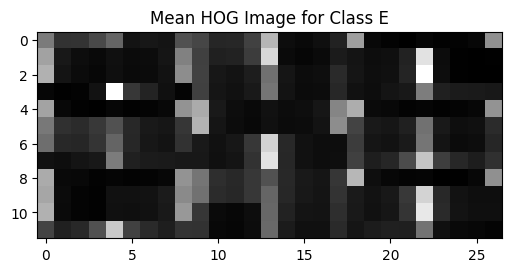

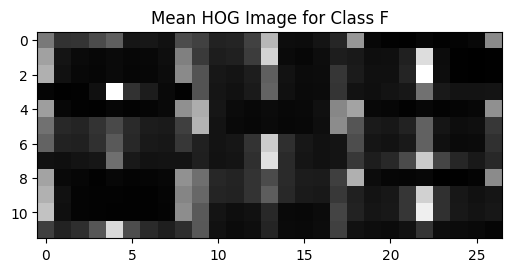

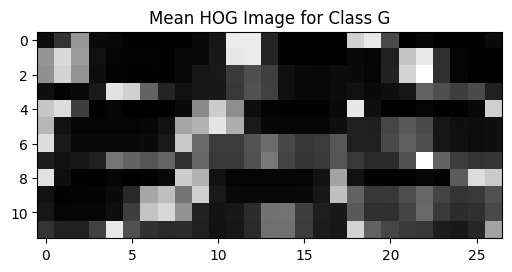

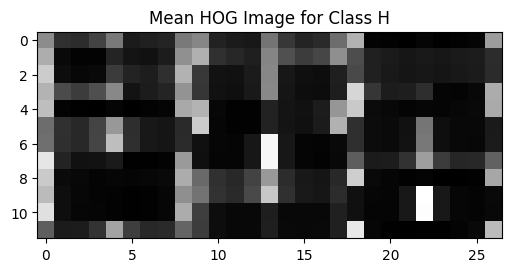

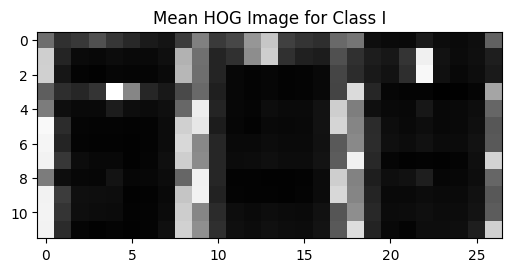

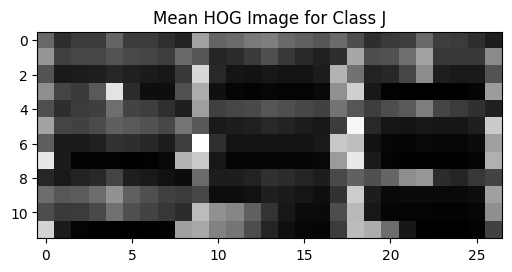

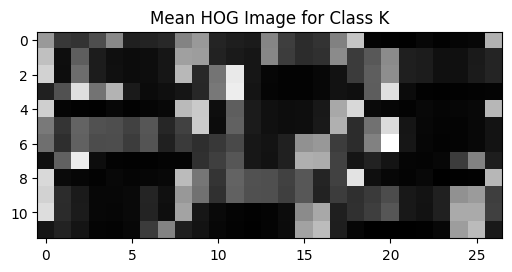

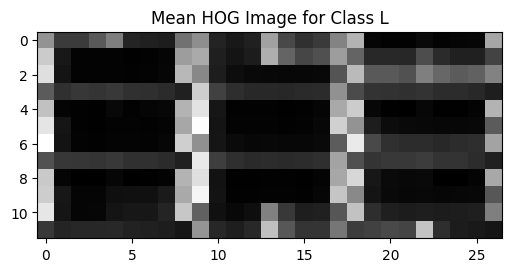

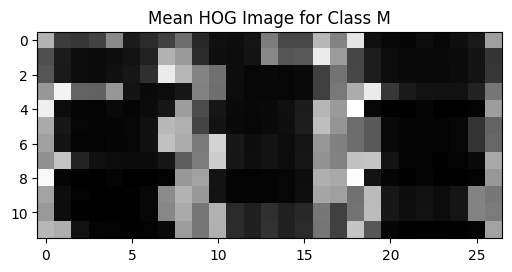

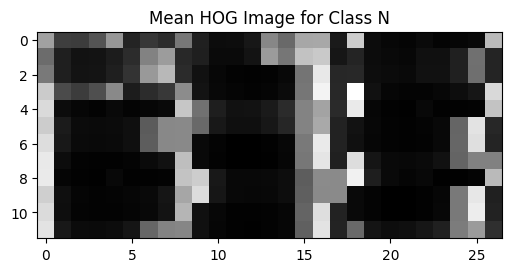

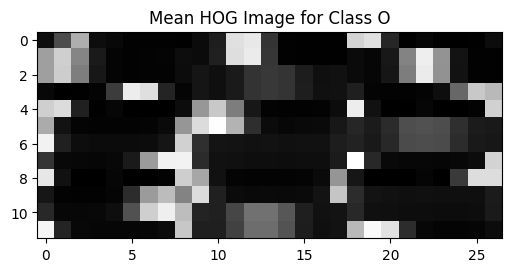

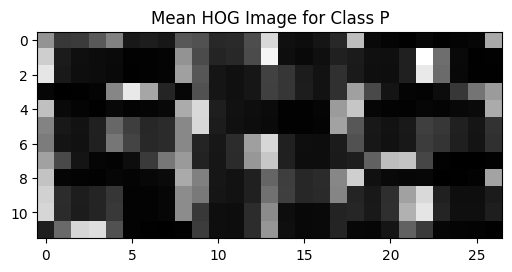

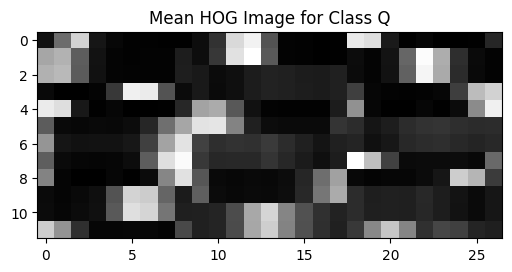

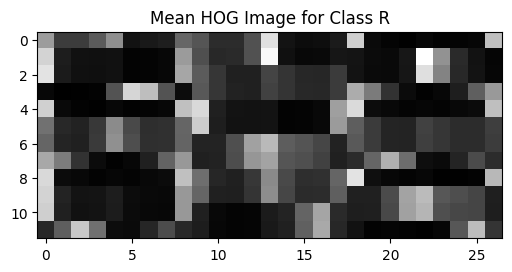

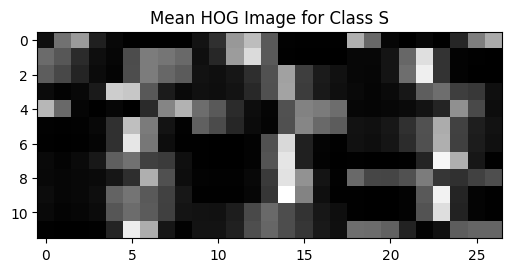

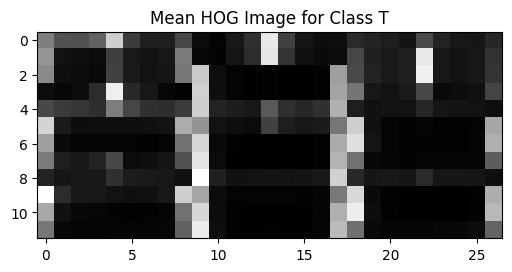

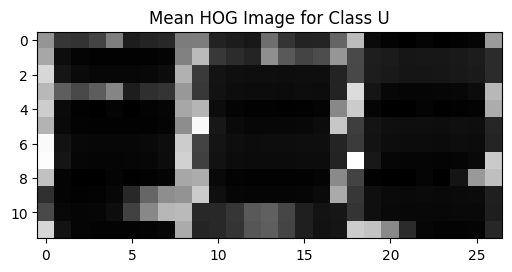

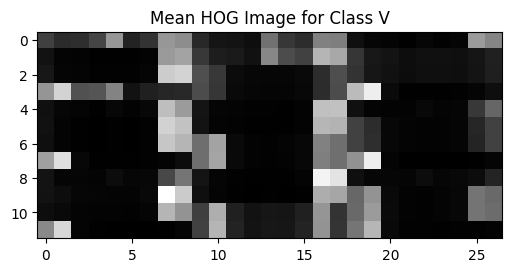

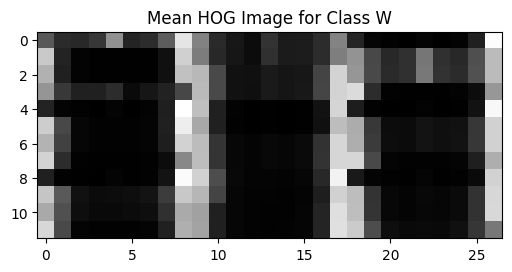

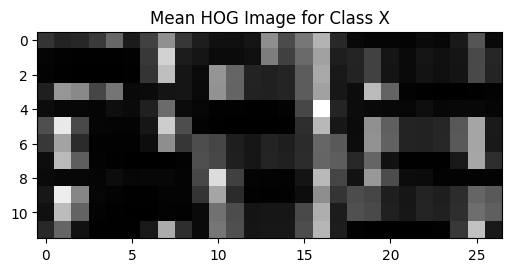

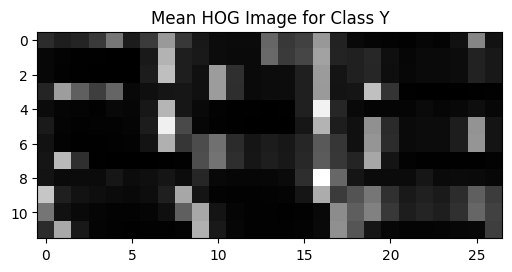

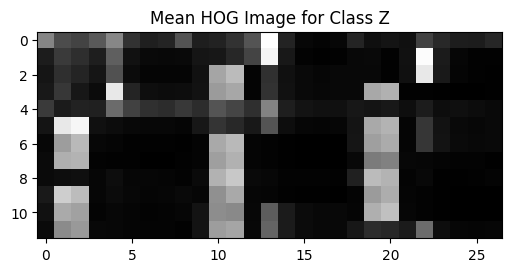

In [19]:
from skimage.feature import hog
import matplotlib.pyplot as plt
import numpy as np


hog_params = {
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'orientations': 9,
    'visualize': False  
}


mean_hog_images_by_class = {}

for label, group_df in grouped_df.items():

    hog_features = []

    for i, row in group_df.iterrows():
        
        image_data = np.array(row[:-1]).reshape((38, 38))  
        features = hog(image_data, **hog_params)

        hog_features.append(features)

    mean_hog_features = np.mean(hog_features, axis=0)

    mean_hog_image = mean_hog_features.reshape((12, 27))

    mean_hog_images_by_class[label] = mean_hog_image


for label, mean_hog_image in mean_hog_images_by_class.items():
    plt.figure(figsize=(6, 6))
    plt.imshow(mean_hog_image, cmap=plt.cm.gray)
    plt.title(f'Mean HOG Image for Class {label}')
    plt.show()


In [20]:
'''
HOG analysis helps us in analysing the noise in the images 

Intensity of the Gradients: HOG captures the intensity of gradients. 
Areas with very faint gradients that don't match the general structure of the digit 
could be a result of noise.

very light or inconsistently dark patches might be indications of areas with 
less meaningful information or noise.

Consider a scenario where I am trying to classify class 7 and class 8.
There is sufficient amount of noise in class 7 that can help me classify between class 7 and class 8

'''

"\nHOG analysis helps us in analysing the noise in the images \n\nIntensity of the Gradients: HOG captures the intensity of gradients. \nAreas with very faint gradients that don't match the general structure of the digit \ncould be a result of noise.\n\nvery light or inconsistently dark patches might be indications of areas with \nless meaningful information or noise.\n\nConsider a scenario where I am trying to classify class 7 and class 8.\nThere is sufficient amount of noise in class 7 that can help me classify between class 7 and class 8\n\n"

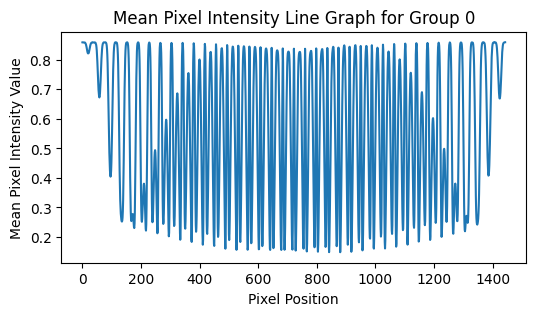

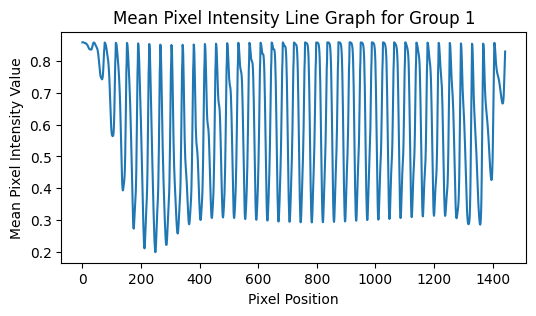

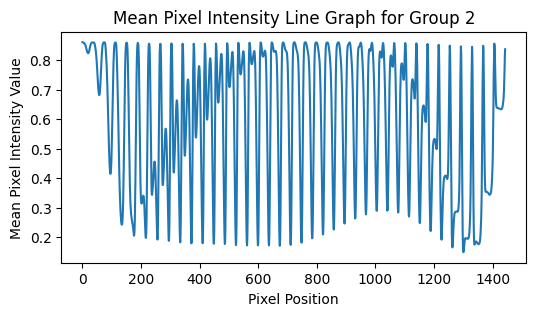

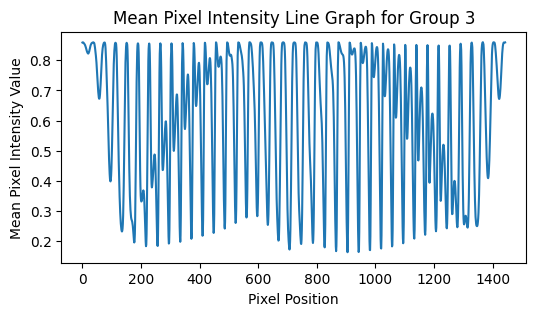

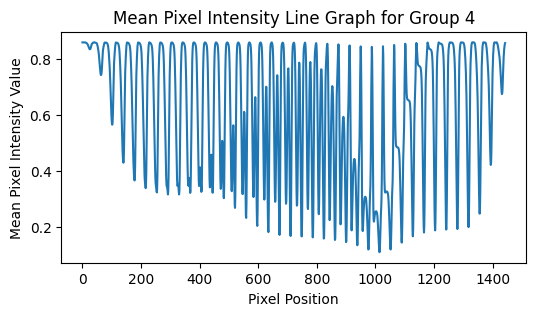

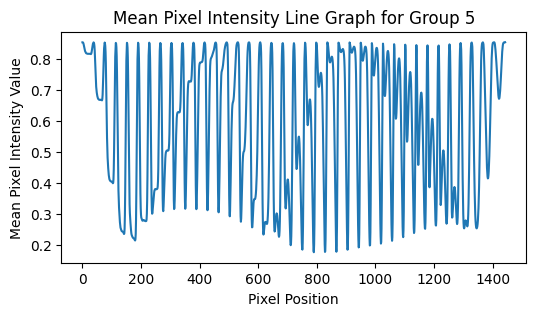

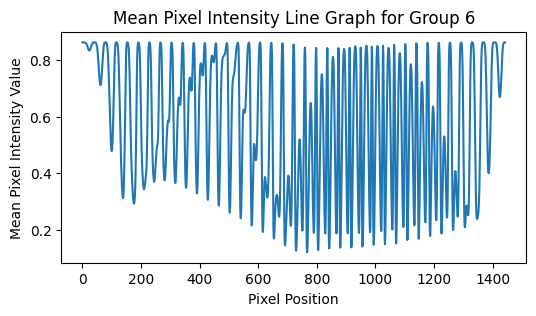

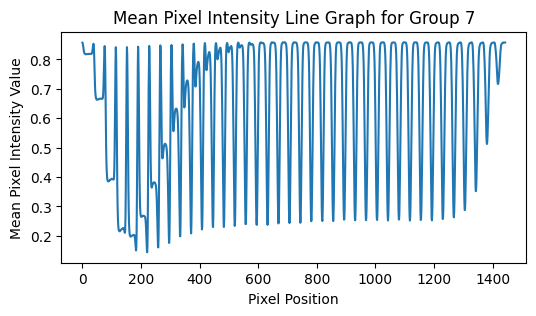

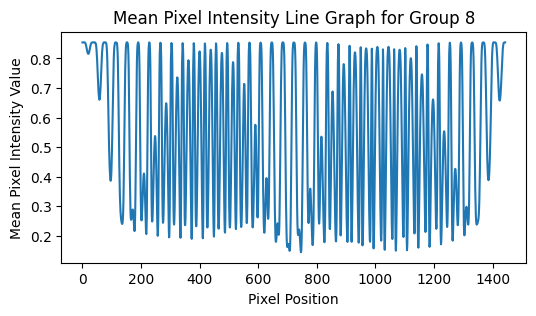

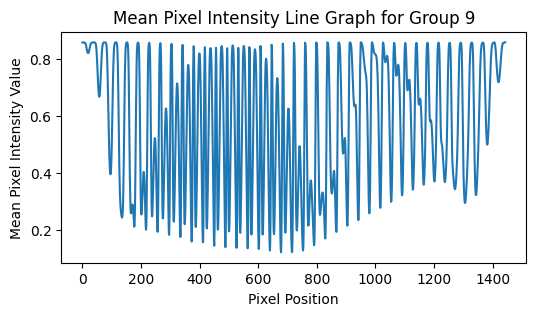

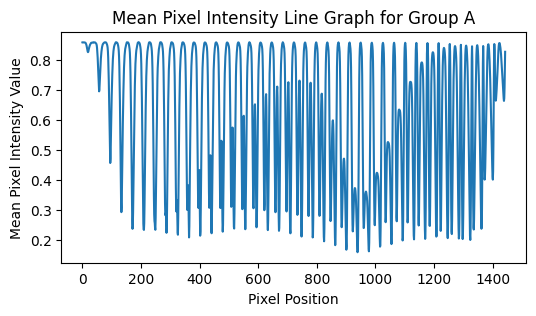

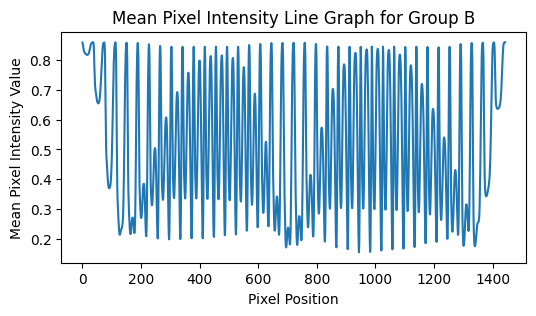

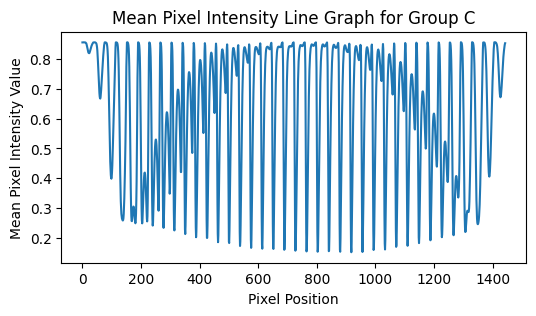

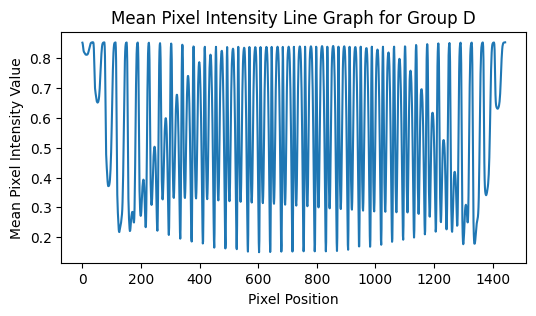

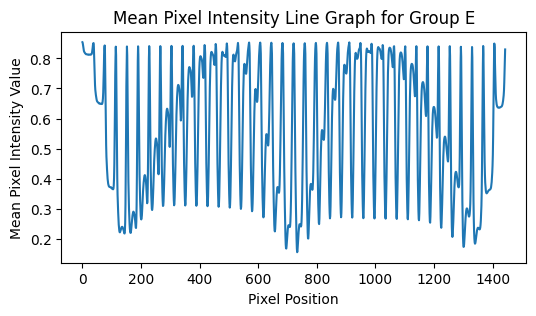

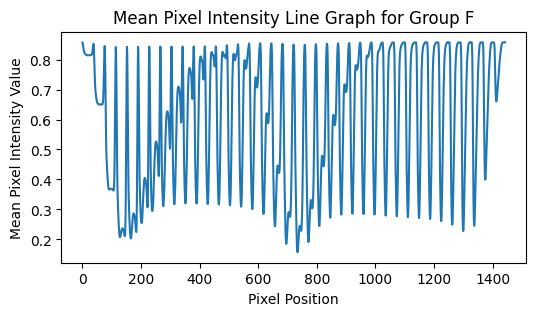

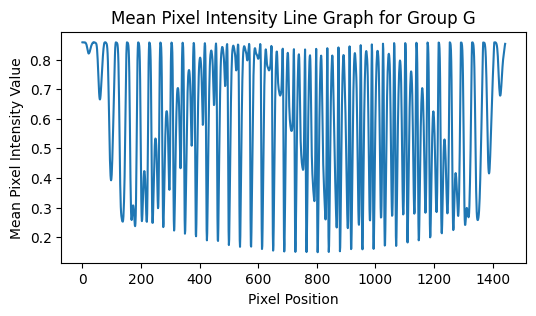

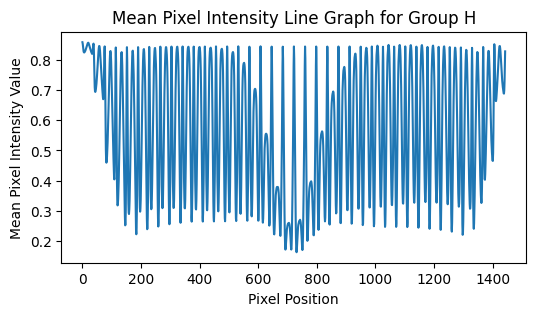

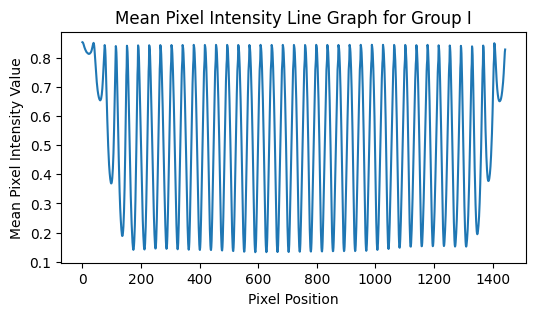

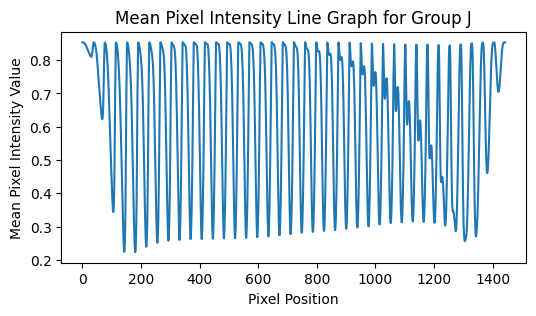

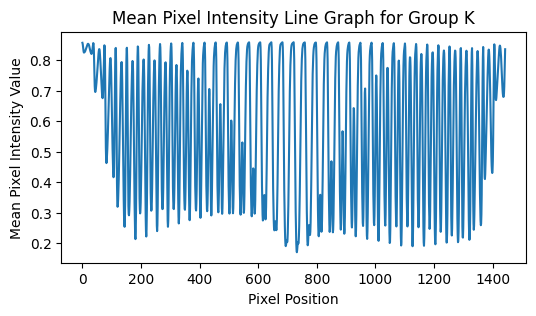

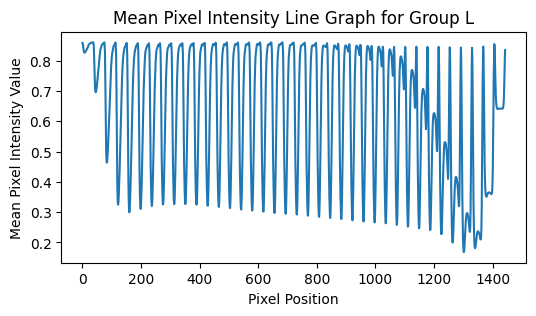

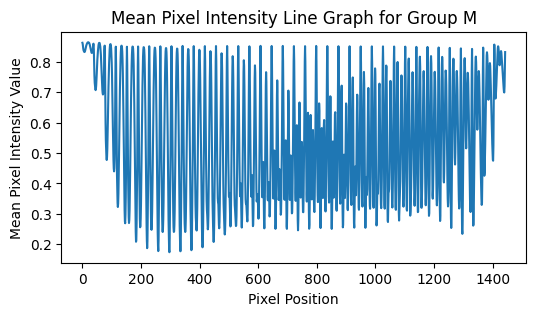

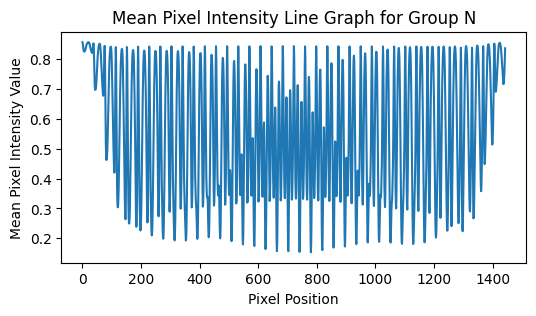

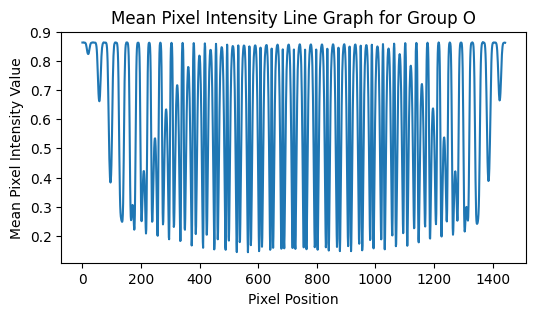

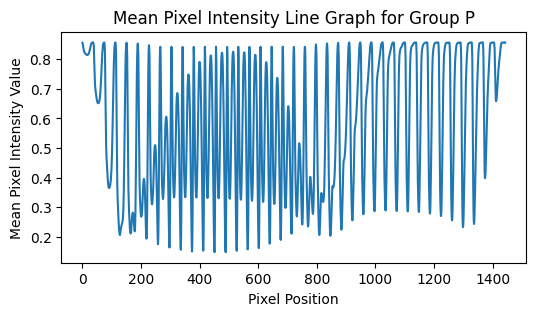

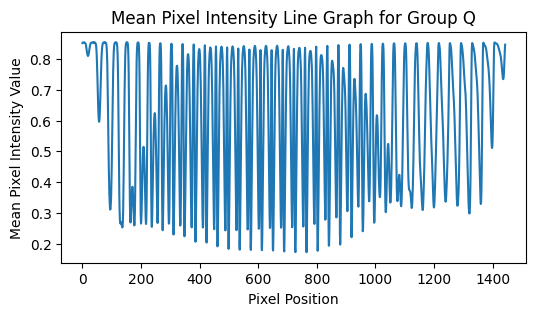

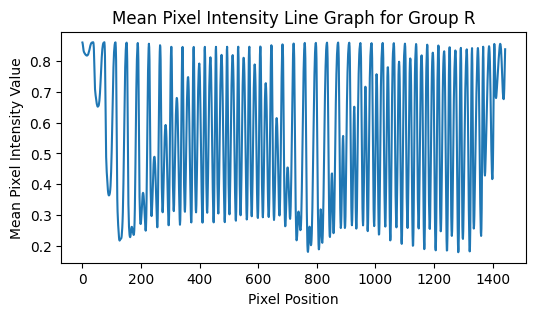

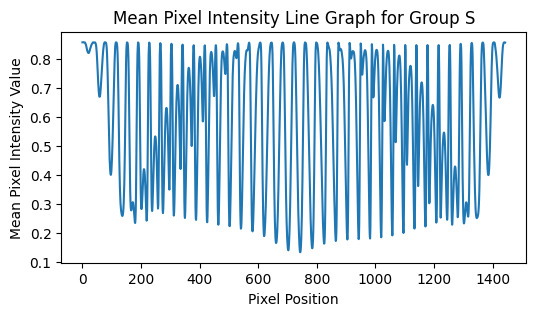

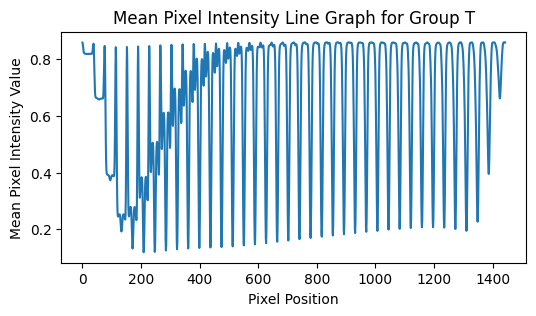

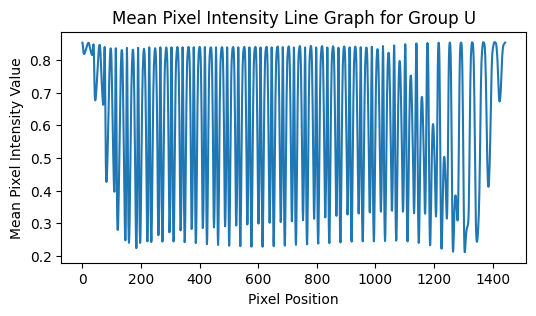

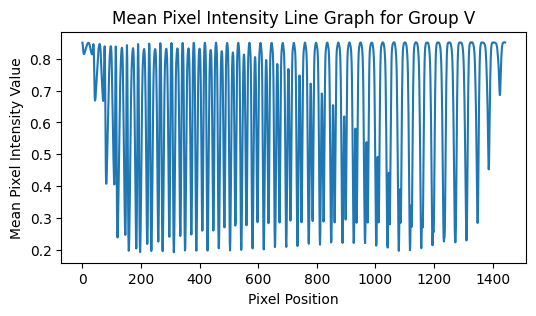

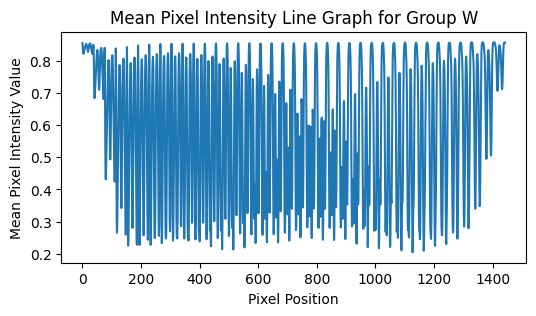

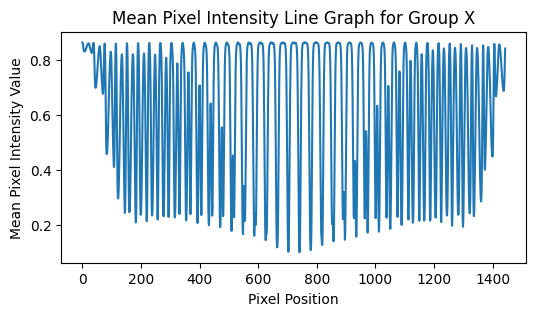

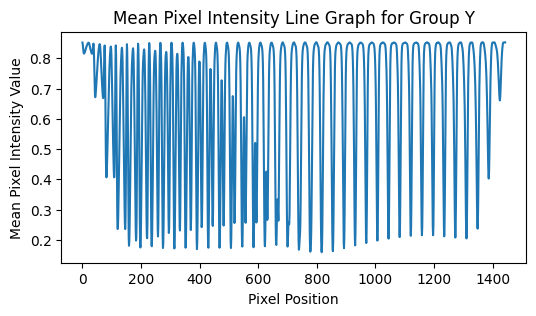

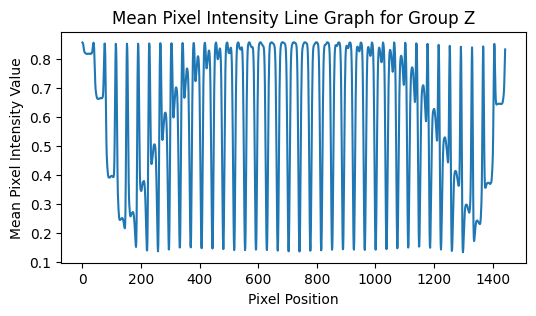

In [21]:
line_graphs = []

for label, group_df in grouped_df.items():

    all_pixel_values = []
    all_intensity_values = []

    for i, row in group_df.iterrows():
        image_data = np.array(row[:-1])
        pixel_values = np.arange(len(image_data))  


        all_pixel_values.append(pixel_values)
        all_intensity_values.append(image_data)


    mean_intensity_values = np.mean(all_intensity_values, axis=0)

    plt.figure(figsize=(6, 3))
    plt.plot(all_pixel_values[0], mean_intensity_values)
    plt.title(f'Mean Pixel Intensity Line Graph for Group {label}')
    plt.xlabel('Pixel Position')
    plt.ylabel('Mean Pixel Intensity Value')
    plt.show()
    
    line_graphs.append((all_pixel_values[0], mean_intensity_values))

In [22]:
# Analysis of Mean pixel intensity 

'''
Here we can see individual class wise mean pixel intensity.
When it comes to classification of characeter/digits Pixel Intensity graphs 
provide insights into the distribution of pixel values (intensities) in an image.

It helps us in classification in the folloing ways:
The positions and heights of peaks in the histogram can provide information about the dominant pixel values, 
which might be characteristic of certain classes of objects or patterns.

For example: Consider the case when you try to classify 8 and 9 
Now look at the peak intensities graph of their respective classes. 

If we closely observe certain pixel positions, we can notice differences between the two graphs:

Around pixel positions 200-800: Group 9 seems to have a generally higher intensity fluctuation than Group 8.
After position 800: Group 8 has higher pixel intensity fluctuations than group 9.

Hence by analysing peak intensity fluctuation we can classify between classes easily.

'''

'\nHere we can see individual class wise mean pixel intensity.\nWhen it comes to classification of characeter/digits Pixel Intensity graphs \nprovide insights into the distribution of pixel values (intensities) in an image.\n\nIt helps us in classification in the folloing ways:\nThe positions and heights of peaks in the histogram can provide information about the dominant pixel values, \nwhich might be characteristic of certain classes of objects or patterns.\n\nFor example: Consider the case when you try to classify 8 and 9 \nNow look at the peak intensities graph of their respective classes. \n\nIf we closely observe certain pixel positions, we can notice differences between the two graphs:\n\nAround pixel positions 200-800: Group 9 seems to have a generally higher intensity fluctuation than Group 8.\nAfter position 800: Group 8 has higher pixel intensity fluctuations than group 9.\n\nHence by analysing peak intensity fluctuation we can classify between classes easily.\n\n'

In [23]:
# training RandomForest

X = df.iloc[:, :-1]  
y = df['label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100,random_state=22,max_depth=10,min_samples_split=5,max_leaf_nodes=100)
rf_clf.fit(X_train, y_train) 

y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:", accuracy)


Accuracy score: 0.9185651963160446


In [24]:
X = test_df.iloc[:, :-1]
y = test_df['label']


y_pred = rf_clf.predict(X)


accuracy = accuracy_score(y, y_pred)
print("Accuracy on testing data:", accuracy)

Accuracy on testing data: 0.9513888888888888


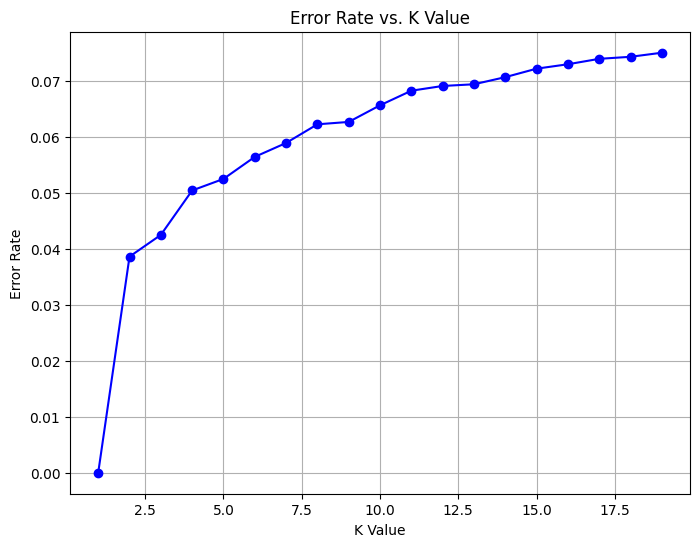

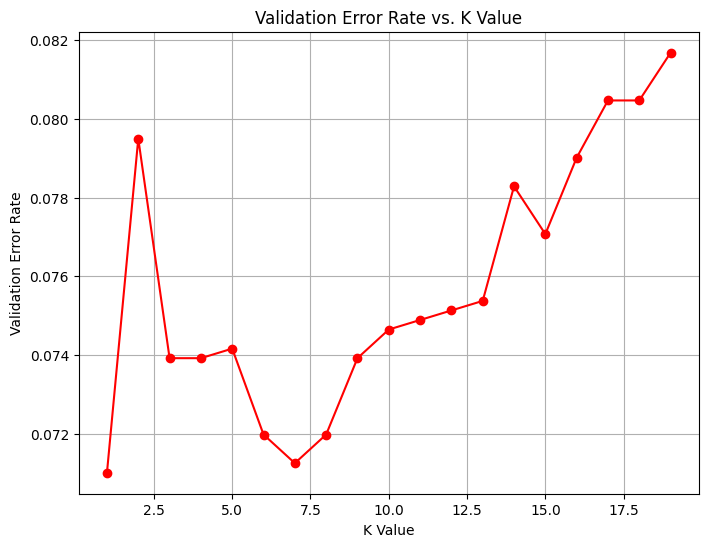

Optimal K based on validation error rate: 1
Accuracy score: 0.9289869122636937


In [25]:
# training KNN

X = df.iloc[:, :-1]  
y = df['label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


k_values = range(1, 20)  
error_rates = []



for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    error_rate = np.mean(y_pred != y_train)
    error_rates.append(error_rate)


plt.figure(figsize=(8, 6))
plt.plot(k_values, error_rates, marker='o', linestyle='-', color='b')
plt.title('Error Rate vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Error Rate')
plt.grid()
plt.show()




validation_error_rates = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_val_pred = knn.predict(X_test)
    validation_error_rate = np.mean(y_val_pred != y_test)
    validation_error_rates.append(validation_error_rate)


plt.figure(figsize=(8, 6))
plt.plot(k_values, validation_error_rates, marker='o', linestyle='-', color='r')
plt.title('Validation Error Rate vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Validation Error Rate')
plt.grid()
plt.show()

optimal_k = k_values[np.argmin(validation_error_rates)]
print("Optimal K based on validation error rate:", optimal_k)


knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:", accuracy)

In [26]:
X = test_df.iloc[:, :-1]
y = test_df['label']


y_pred = knn.predict(X)

accuracy = accuracy_score(y, y_pred)
print("Accuracy on testing data:", accuracy)

Accuracy on testing data: 0.9732142857142857


In [27]:
# training SVM

X = df.iloc[:, :-1]  
y = df['label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train, y_train)


y_pred = svm_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)


Accuracy on test data: 0.956858943286476


In [28]:
X = test_df.iloc[:, :-1]
y = test_df['label']


y_pred = svm_clf.predict(X)


accuracy = accuracy_score(y, y_pred)
print("Accuracy on testing data:", accuracy)

Accuracy on testing data: 0.9930555555555556


In [32]:
# k-fold validation on all models

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score  

K = 5

kf = KFold(n_splits=K, shuffle=True, random_state=42)


X = df.iloc[:, :-1]  
y = df['label']  


svm_scores = []
knn_scores = []
rf_scores = []


for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    svm_clf.fit(X_train, y_train)
    svm_predictions = svm_clf.predict(X_test)
    svm_scores.append(accuracy_score(y_test, svm_predictions))
    

    knn.fit(X_train, y_train)
    knn_predictions = knn.predict(X_test)
    knn_scores.append(accuracy_score(y_test, knn_predictions))
    

    rf_clf.fit(X_train, y_train)
    rf_predictions = rf_clf.predict(X_test)
    rf_scores.append(accuracy_score(y_test, rf_predictions))
    
    

average_svm_score = sum(svm_scores) / K
average_knn_score = sum(knn_scores) / K
average_rf_score = sum(rf_scores) / K

print(f"Average SVM Score: {average_svm_score}")
print(f"Average KNN Score: {average_knn_score}")
print(f"Average RF Score: {average_rf_score}")

Average SVM Score: 0.9564183364653568
Average KNN Score: 0.9337310462431467
Average RF Score: 0.9187029050477374


In [44]:
# XgBoosting 

import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder



label_encoder = LabelEncoder()


df['label'] = label_encoder.fit_transform(df['label'])

X = df.iloc[:, :-1]  
y = df['label']  

data_dmatrix = xgb.DMatrix(data=X,label=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

params = {
    'objective': 'multi:softmax',
    'num_class': 36,  # Replace with the actual number of classes
    'max_depth': 10,
    'alpha': 10,
    'learning_rate': 0.75,
    'n_estimators': 100
}
            
            
xgb_clf = XGBClassifier(**params)

xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

XGBoost model accuracy score: 0.8889


In [49]:
from xgboost import cv

params = {
    'objective': 'multi:softmax',
    'num_class': 36,  # Replace with the actual number of classes
    'max_depth': 10,
    'alpha': 10,
    'learning_rate': 0.75,
    'n_estimators': 100,
    
}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)


xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.990614,0.000354,0.976844,0.001488
1,0.992702,0.003980,0.980885,0.003134
2,0.992283,0.008051,0.980222,0.009404
3,0.993789,0.007305,0.981719,0.009518
4,0.994333,0.007441,0.983271,0.008491


In [50]:
import os


def create_file_listing_paths(folder_path, output_file_name):

    if not os.path.isdir(folder_path):
        return "The provided path is not a directory."
    

    image_paths = []
    

    for root, dirs, files in os.walk(folder_path):
        for file in files:

            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):

                image_paths.append(os.path.join(root, file))
    

    with open(output_file_name, 'w') as f:
        for path in image_paths:
            f.write(path + "\n")
    

    return os.path.abspath(output_file_name)


root_path = "archive/data/testing_data"

output_file_name = "demo-testing.txt"

result = create_file_listing_paths(root_path, output_file_name)


'/Users/parthivdholaria/Desktop/PARTHIV/IIIT DELHI/SEM5/ML/Project/demo-testing.txt'